# Loading Raw Ephys Data (AP and LFP band)

In [ ]:
# Turn off logging, this is a hidden cell on docs page
import logging
logger = logging.getLogger('ibllib')
logger.setLevel(logging.CRITICAL)

Raw electrophysiology data recorded using spikeglx and compressed using mtscomp

## Relevant datasets
* \_spikeglx_ephysData*.cbin
* \_spikeglx_ephysData*.meta
* \_spikeglx_ephysData*.ch

## Loading

### Option 1: Stream snippets of raw ephys data
This is a useful option if you are interested to perform analysis on a chunk of data of smaller duration than the whole recording, as it will take less time to download. Data snippets can be loaded in chunks of 1-second, i.e. you can load at minimum 1 second of raw data, and any multiplier of such chunk length (for example 4 or 92 seconds).

In [2]:
from one.api import ONE
from brainbox.io.spikeglx import Streamer

one = ONE()

pid = 'da8dfec1-d265-44e8-84ce-6ae9c109b8bd'

time0 = 100 # timepoint in recording to stream
time_win = 1 # number of seconds to stream
band = 'ap' # either 'ap' or 'lf'

sr = Streamer(pid=pid, one=one, remove_cached=False, typ=band)
s0 = time0 * sr.fs
tsel = slice(int(s0), int(s0) + int(time_win * sr.fs))

# Important: remove sync channel from raw data, and transpose
raw = sr[tsel, :-sr.nsync].T

Downloading: /Users/gaelle/Downloads/FlatIron/tmpt7sci3pv/cache.zip Bytes: 87351518


100%|██████████| 83.30489921569824/83.30489921569824 [00:04<00:00, 19.61it/s]


<div class="alert alert-info">
Notes:

- the transpose (`.T`) for internal representation of the `raw` data. On disk, the data is multiplexed; this is not desirable for pre-processing, as it renders it much slower. This is why our internal representation for the raw data (i.e. dimensions used when working with such data) is `[number of channels, number of samples]`.

- the raw data will contain the synching channels (i.e. the voltage information contained on the analog and digital DAQ channels, that mark events in the task notably). You need to remove them before wanting to use solely the raw data (e.g. for plotting or exploring).

</div>

### Option 2: Download all of raw ephys data

<div class="alert alert-warning">
Warning.

The raw ephys data is very large and downloading will take a long period of time
</div>

In [ ]:
from one.api import ONE
import spikeglx
one = ONE()

pid = 'da8dfec1-d265-44e8-84ce-6ae9c109b8bd'
eid, probe = one.pid2eid(pid)

band = 'ap' # either 'ap','lf'

# Find the relevant datasets and download
dsets = one.list_datasets(eid, collection=f'raw_ephys_data/{probe}', filename=f'*{band}*', details=True)

# Option 1. If you simply want to download the raw data (note that it will also contain the synching channels):
data = one.load_datasets(eid, dsets, download_only=True)

# Option 2. If you want to download the raw data with spikeGLX meta information:
dset_paths = one._download_datasets(dsets)
# Find the .bin file
bin_file = next(dset_paths[0].parent.glob(f'*{band}.*bin'))

# Use spikeglx reader to read in the whole raw data
sr_all = spikeglx.Reader(bin_file)

## More details
* [Details of raw ap datasets](https://docs.google.com/document/d/1OqIqqakPakHXRAwceYLwFY9gOrm8_P62XIfCTnHwstg/edit#heading=h.ms0y69xbzova)
* [Details of raw lfp datasets](https://docs.google.com/document/d/1OqIqqakPakHXRAwceYLwFY9gOrm8_P62XIfCTnHwstg/edit#heading=h.nct1c3j9tedk)
* [Details of mtscomp compression algorithm](https://github.com/int-brain-lab/mtscomp#readme)
* [Spikesorting white paper](https://figshare.com/articles/online_resource/Spike_sorting_pipeline_for_the_International_Brain_Laboratory/19705522)

## Useful modules
* [ibllib.io.spikeglx](https://int-brain-lab.github.io/ibl-neuropixel/_autosummary/spikeglx.html)
* [ibllib.voltage.dsp](https://int-brain-lab.github.io/ibl-neuropixel/_autosummary/neurodsp.voltage.html)
* [brainbox.io.spikeglx.stream](https://int-brain-lab.github.io/iblenv/_autosummary/brainbox.io.spikeglx.html#brainbox.io.spikeglx.stream)
* [viewephys](https://github.com/oliche/viewephys) to visualise raw data snippets (Note: this package is not within `ibllib` but standalone)

## Exploring raw ephys data

### Example 1: Destripe AP data
This is very important to do prior to using the raw data, as it removes artifacts (see our [Spikesorting white paper](https://figshare.com/articles/online_resource/Spike_sorting_pipeline_for_the_International_Brain_Laboratory/19705522) for details).

In [4]:
from neurodsp.voltage import destripe
# Reminder : If not done before, remove first the sync channel from raw data
# Apply destriping algorithm to data
destriped = destripe(raw, fs=sr.fs)

To view and explore the raw ephys data, we recommend you use the [viewephys tool](https://github.com/oliche/viewephys).

In [ ]:
from viewephys.gui import viewephys
v_raw = viewephys(raw, fs=sr.fs)
v_des = viewephys(destriped, fs=sr.fs)
# You will then be able to zoom in, adjust the gain etc - see README for details

For the sake of presenting the data pre and post destriping as part of this tutorial, we are using an alternative plotting method (`matplotlib`).

Text(0, 0.5, '')

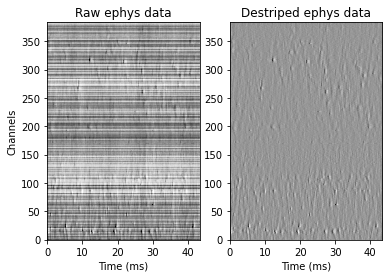

In [8]:
from ibllib.plots import Density
import matplotlib.pyplot as plt

DISPLAY_TIME = 0.05  # second
SAMPLE_SKIP = 200  # Skip beginning for show, otherwise blurry due to filtering edge effect
MIN_X = -0.00011
MAX_X = -MIN_X

# Shorten and transpose the data for plotting
X = destriped[:, :int(DISPLAY_TIME * sr.fs)].T
Xs = X[SAMPLE_SKIP:].T  # Remove artifact at begining
Tplot = Xs.shape[1]/sr.fs

X_raw = raw[:, :int(DISPLAY_TIME * sr.fs)].T
Xs_raw = X_raw[SAMPLE_SKIP:].T  # Remove artifact at begining

# Plot
fig, axs = plt.subplots(nrows=1, ncols=2)

i_plt = 0
d0 = Density(-Xs_raw, fs=sr.fs, taxis=1, ax=axs[i_plt],  vmin=MIN_X, vmax=MAX_X, cmap='Greys')
axs[i_plt].title.set_text('Raw ephys data')
axs[i_plt].set_xlim((0, Tplot * 1e3))
axs[i_plt].set_ylabel('Channels')

i_plt = 1
d1 = Density(-Xs, fs=sr.fs, taxis=1, ax=axs[i_plt],  vmin=MIN_X, vmax=MAX_X, cmap='Greys')
axs[i_plt].title.set_text('Destriped ephys data')
axs[i_plt].set_xlim((0, Tplot * 1e3))
axs[i_plt].set_ylabel('')

### Example 2: Stream LFP data around task event
The example downloads a 1-second snippet of raw LF data ; all that needs setting as parameters are the `time0` (the time of the even of interest), the `band` (LFP), and the duration `time_win` (1 second).

In [9]:
eid, probe = one.pid2eid(pid)
stimOn_times = one.load_object(eid, 'trials', collection='alf')['stimOn_times']
event_no = 100

# Get the 1s of LFP data around time point of interest
time0 = stimOn_times[event_no] # timepoint in recording to stream
time_win = 1 # number of seconds to stream
band = 'lf' # either 'ap' or 'lf'

sr = Streamer(pid=pid, one=one, remove_cached=False, typ=band)
s0 = time0 * sr.fs
tsel = slice(int(s0), int(s0) + int(time_win * sr.fs))
# remove sync channel from raw data
raw = sr[tsel, :-sr.nsync].T
# apply destriping algorithm to data
destriped = destripe(raw, fs=sr.fs)

## Other relevant examples
* COMING SOON